In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import os.path


from numpy import array
from datetime import timedelta  
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import LSTM, GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, AveragePooling1D
from fbprophet import Prophet
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from pmdarima import auto_arima
from datetime import timedelta 
import tensorflow as tf

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

Using TensorFlow backend.


In [2]:
timestamp = "timestamp"
predictionColumn = "cpuusage_ps"

In [3]:
# setting rand seeds to enhance reproducability, since weights are inited randomly
np.random.seed(4589)
tf.random.set_seed(2457)


In [4]:
def plot_real_data_train(df, pred_horizon):
    data = df.reset_index()[[timestamp, predictionColumn]][:-pred_horizon]
    data.columns = ['date','Train Data']
    data.set_index('date', inplace=True)
    return data

def plot_real_data_test(df, pred_horizon):
    data = df.reset_index()[[timestamp, predictionColumn]]
    data = data.tail(pred_horizon)
    data.columns = ['date','Test Data']
    data.set_index('date', inplace=True)
    return data

In [5]:
plotly.offline.init_notebook_mode(connected=True)

def plot_data(df, plotTitle):
    map_plotly_series = dict()
    for columnName in df.columns:
        s = go.Scatter(
            x=df.index,
            y=df[columnName],
            name = columnName,
            hoverinfo='none',
            opacity = 0.8)
        map_plotly_series[columnName] = s
    data = list(map_plotly_series.values())
    layout = dict(
        title = plotTitle,
        xaxis = dict(
            range = [df.index.min(),df.index.max()])
    )
    fig = dict(data=data, layout=layout)
    plotly.offline.plot(fig, filename = plotTitle + '.html')
    return None 

In [6]:
def generate_index_forecast(df, df_forecast, pred_horizon):
    minutesBetweenMeasures = 15
    temp = df.reset_index()[[timestamp]]
    lastTrainDataTimeStamp = temp.tail(pred_horizon)[timestamp].iloc[0]
    nextTimeStamp = lastTrainDataTimeStamp
    for i in df_forecast.index:
        nextTimeStamp = nextTimeStamp + timedelta(minutes=minutesBetweenMeasures)
        df_forecast.at[i, 'date'] = nextTimeStamp
    df_forecast.set_index('date', inplace=True)
    return df_forecast 

def calculateMSE_RMSE(df, real, prediction):
    from sklearn.metrics import mean_squared_error, r2_score
    from math import sqrt

    mse = mean_squared_error(real, prediction)
    rmse = sqrt(mse)
    r2 = r2_score(real, prediction)
    
    print("********MSE, RMSE, R^2******")
    print("MSE: %f" % mse)
    print("RMSE: %f" % rmse)
    print("R squared: %f" % r2)
    

In [84]:
# split a multivariate sequence into samples
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def split_train_test(x, y):
    x_train = x[:-1]
    x_test = x[-1:]
    y_train = y[:-1]
    y_test = y[-1:]

    return x_train, x_test, y_train, y_test

def split_train_validation(x, y, split):
    x_train = x[:-split]
    x_val = x[-split:]
    y_train = y[:-split]
    y_val = y[-split:]
    
    return x_train, x_val, y_train, y_val

In [8]:
def lstm_data_preprocessing(df, n_history, pred_horizon, performPCA):
    if not df.index.name == timestamp:
        dataset = df.set_index(timestamp)
    else:
        dataset = df
    
    y = dataset[predictionColumn].copy()
    x = dataset.drop(columns=predictionColumn)
    
    scalerX = StandardScaler()
    scalerX.fit(x)
    x = scalerX.transform(x)
    scalerY = StandardScaler()
   # .reshape(-1, 1) # needed for standardScaler
    scalerY.fit(y.values.reshape(-1,1))
    y = scalerY.transform(y.values.reshape(-1,1))
    
    if(performPCA):
        pcaTransformer = PCA(0.95) # keep 95% variance
        pcaTransformer.fit(x)
        x = pcaTransformer.transform(x)
        print(''' *** PCA Result***\n Started with %d features, reduced to %d features''' 
              % (len(df.columns)-1, pcaTransformer.n_components_))
        
    transformed_df = pd.DataFrame().from_records(x)
    transformed_df[predictionColumn] = y
    
    transformed_df.reset_index(inplace=True)
    x, y = split_sequences(transformed_df.values, n_steps_in=n_history, n_steps_out=pred_horizon)
    return x, y, scalerX, scalerY


def train_lstm(df, n_history, pred_horizon, performPCA=False, forcePreprocessing=False):
    preprocessingResultFile = "lstm_preprocessingResult.pkl"
    if not os.path.isfile(preprocessingResultFile) or forcePreprocessing:
        print("Preprocessing data...")
        # data split / preprocessing
        x, y, scalerX, scalerY = lstm_data_preprocessing(df, n_history=n_history, pred_horizon=pred_horizon, performPCA=performPCA)
        print("SHAPES: ", x.shape, y.shape)
        numberOfFeatures = x.shape[2]
        x_train, x_test, y_train, y_test = split_train_test(x, y)
        # split training test again into train and validation set
        x_train, x_val, y_train, y_val = split_train_validation(x_train, y_train, int(x_train.shape[0] * 0.15))
        print("Shapes: xtr, xte, ytr, yte, x_val, y_val: ", x_train.shape, x_test.shape, 
              y_train.shape, y_test.shape, x_val.shape, y_val.shape)
        preprocessingResult = [x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY]
        with(open(preprocessingResultFile, "wb")) as pkl:
            pickle.dump(preprocessingResult, pkl)
    else:
        with(open(preprocessingResultFile, "rb")) as pkl:
            x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)
        numberOfFeatures = x_train.shape[2]
            
    # model definition
    model = Sequential()
    model.add(LSTM(75, activation='tanh', return_sequences=True, input_shape=(n_history, numberOfFeatures)))
    model.add(LSTM(75, activation="tanh", return_sequences=True))
    model.add(LSTM(75, activation="tanh", return_sequences=True))
    model.add(LSTM(75, activation="tanh", return_sequences=True))
    model.add(LSTM(75, activation="tanh"))
    model.add(Dense(pred_horizon))
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('switchedPca_lstm_multistep_multivariate.h5', monitor='val_loss' , mode='min', verbose=1, save_best_only=True)
    # model train
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=400, callbacks=[es, mc])
    print('''*** Model fitted ***''')
    return None

def forecast_lstm(df, n_history, pred_horizon):
    model = load_model('lstm_multistep_multivariate.h5')
    with(open("lstm_preprocessingResult.pkl", "rb")) as pkl:
        x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)
    numberOfFeatures = x_train.shape[2]
    
    pred_input = x_test
    #pred_input = pred_input.reshape((1, pred_input.shape[0],pred_input.shape[1]))
    
    prediction = model.predict(pred_input)
    prediction = prediction.reshape((pred_horizon,1))
    prediction = scalerY.inverse_transform(prediction)
    prediction = np.hstack((prediction, np.zeros((prediction.shape[0], numberOfFeatures-1), dtype=prediction.dtype)))

    y_test = y_test.reshape((pred_horizon, 1))
    realValues = scalerY.inverse_transform(y_test)
    calculateMSE_RMSE(df, realValues, prediction[:,0]) #reshape from (pred_horizon,1) to (pred_horizon)
    
    df_forecast = pd.DataFrame(prediction[:,[0]], columns=['LSTM'])
    return generate_index_forecast(df, df_forecast, pred_horizon=pred_horizon)

In [9]:
def gru_data_preprocessing(df, n_history, pred_horizon, performPCA):
    if not df.index.name == timestamp:
        dataset = df.set_index(timestamp)
    else:
        dataset = df
    
    y = dataset[predictionColumn].copy()
    x = dataset.drop(columns=predictionColumn)
    
    scalerX = StandardScaler()
    scalerX.fit(x)
    x = scalerX.transform(x)
    scalerY = StandardScaler()
   # .reshape(-1, 1) # needed for standardScaler
    scalerY.fit(y.values.reshape(-1,1))
    y = scalerY.transform(y.values.reshape(-1,1))
    
    if(performPCA):
        pcaTransformer = PCA(0.95) # keep 95% variance
        pcaTransformer.fit(x)
        x = pcaTransformer.transform(x)
        print(''' *** PCA Result***\n Started with %d features, reduced to %d features''' 
              % (len(df.columns)-1, pcaTransformer.n_components_))
        
    transformed_df = pd.DataFrame().from_records(x)
    transformed_df[predictionColumn] = y
    
    transformed_df.reset_index(inplace=True)
    x, y = split_sequences(transformed_df.values, n_steps_in=n_history, n_steps_out=pred_horizon)
    return x, y, scalerX, scalerY


def train_gru(df, n_history, pred_horizon, performPCA=False, forcePreprocessing=False):
    preprocessingResultFile = "gru_preprocessingResult.pkl"
    if not os.path.isfile(preprocessingResultFile) or forcePreprocessing:
        print("Preprocessing data...")
        # data split / preprocessing
        x, y, scalerX, scalerY = gru_data_preprocessing(df, n_history=n_history, pred_horizon=pred_horizon, performPCA=performPCA)
        print("SHAPES: ", x.shape, y.shape)
        numberOfFeatures = x.shape[2]
        x_train, x_test, y_train, y_test = split_train_test(x, y)
        # split training test again into train and validation set
        x_train, x_val, y_train, y_val = split_train_validation(x_train, y_train,  int(x_train.shape[0] * 0.15))
        print("Shapes: xtr, xte, ytr, yte, x_val, y_val: ", x_train.shape, x_test.shape, 
              y_train.shape, y_test.shape, x_val.shape, y_val.shape)
        preprocessingResult = [x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY]
        
        with(open(preprocessingResultFile, "wb")) as pkl:
            pickle.dump(preprocessingResult, pkl)
    else:
        with(open(preprocessingResultFile, "rb")) as pkl:
            x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)
        numberOfFeatures = x_train.shape[2]
            
    # model definition
    model = Sequential()
    model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_history, numberOfFeatures)))
    model.add(GRU(50, activation="relu", return_sequences=True))
    model.add(GRU(50, activation="relu", return_sequences=True))
    model.add(GRU(50, activation="relu", return_sequences=True))
    model.add(GRU(50, activation="relu", return_sequences=True))
    model.add(GRU(50, activation="relu"))
    model.add(Dense(pred_horizon))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('switchedPca_gru_multistep_multivariate.h5', monitor='val_loss' , mode='min', verbose=1, save_best_only=True)
    # model train
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=400, callbacks=[es, mc])
    print('''*** Model fitted ***''')
    return None

def forecast_gru(df, n_history, pred_horizon):
    model = load_model('gru_multistep_multivariate.h5')
    with(open("gru_preprocessingResult.pkl", "rb")) as pkl:
        x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)
    numberOfFeatures = x_train.shape[2]
    pred_input = x_test
    #pred_input = pred_input.reshape((1, pred_input.shape[0],pred_input.shape[1]))
    
    prediction = model.predict(pred_input)
    prediction = prediction.reshape((pred_horizon,1))
    prediction = scalerY.inverse_transform(prediction)
    prediction = np.hstack((prediction, np.zeros((prediction.shape[0], numberOfFeatures-1), dtype=prediction.dtype)))

    
    y_test = y_test.reshape((pred_horizon, 1))
    realValues = scalerY.inverse_transform(y_test)
    calculateMSE_RMSE(df, realValues, prediction[:,0]) #reshape from (pred_horizon,1) to (pred_horizon)
    
    df_forecast = pd.DataFrame(prediction[:,[0]], columns=['GRU'])
    return generate_index_forecast(df, df_forecast, pred_horizon=pred_horizon)

In [10]:
def mlp_data_preprocessing(df, n_history, pred_horizon, performPCA):
    if not df.index.name == timestamp:
        dataset = df.set_index(timestamp)
    else:
        dataset = df
         
    y = dataset[predictionColumn].copy()
    x = dataset.drop(columns=predictionColumn)
    
    scalerX = StandardScaler()
    scalerX.fit(x)
    x = scalerX.transform(x)
    scalerY = StandardScaler()
   # .reshape(-1, 1) # needed for standardScaler
    scalerY.fit(y.values.reshape(-1,1))
    y = scalerY.transform(y.values.reshape(-1,1))
    
    if(performPCA):
        pcaTransformer = PCA(0.95) # keep 95% variance
        pcaTransformer.fit(x)
        x = pcaTransformer.transform(x)
        print(''' *** PCA Result***\n Started with %d features, reduced to %d features''' 
              % (len(df.columns)-1, pcaTransformer.n_components_))
        
    transformed_df = pd.DataFrame().from_records(x)
    transformed_df[predictionColumn] = y
    
    transformed_df.reset_index(inplace=True)
    x, y = split_sequences(transformed_df.values, n_steps_in=n_history, n_steps_out=pred_horizon)
    return x, y, scalerX, scalerY


def train_mlp(df, n_history, pred_horizon, performPCA=True, forcePreprocessing=False):
    preprocessingResultFile = "mlp_preprocessingResult.pkl"
    if not os.path.isfile(preprocessingResultFile) or forcePreprocessing:
        print("Preprocessing data...")
        x, y, scalerX, scalerY = mlp_data_preprocessing(df, n_history=n_history, pred_horizon=pred_horizon, performPCA=performPCA)
        print("SHAPES: ", x.shape, y.shape)
        x_train, x_test, y_train, y_test = split_train_test(x, y)
        # split training test again into train and validation set
        x_train, x_val, y_train, y_val = split_train_validation(x_train, y_train,  int(x_train.shape[0] * 0.15))
        print("Shapes: xtr, xte, ytr, yte, x_val, y_val: ", x_train.shape, x_test.shape, 
              y_train.shape, y_test.shape, x_val.shape, y_val.shape)
        
        n_input = x_train.shape[1] * x_train.shape[2]
        x_train = x_train.reshape((x_train.shape[0], n_input))
        x_val = x_val.reshape((x_val.shape[0], n_input))
        n_neurons = int((n_input + pred_horizon))
        preprocessingResult = [n_input, x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY]
        with(open(preprocessingResultFile, "wb")) as pkl:
            pickle.dump(preprocessingResult, pkl)
    else:
        with(open(preprocessingResultFile, "rb")) as pkl:
            n_input, x_train, x_test, y_train, y_test, scalerX, scalerY = pickle.load(pkl)
        n_neurons = int((n_input + pred_horizon)//2)
        
    model = Sequential()
    model.add(Dense(n_neurons, activation='tanh', input_dim=n_input))
    model.add(Dense(n_neurons//2, activation="tanh"))
    model.add(Dense(n_neurons//2, activation="tanh"))
    model.add(Dense(n_neurons, activation="tanh"))
    model.add(Dense(pred_horizon))
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('switchedPca_mlp_multistep_multivariate.h5', monitor='val_loss' , mode='min', verbose=1, save_best_only=True)    
    model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=400, callbacks=[es, mc])
    return None

def forecast_mlp(df, n_history, pred_horizon):
    model_mlp = load_model('mlp_multistep_multivariate.h5')
    with(open("mlp_preprocessingResult.pkl", "rb")) as pkl:
        n_input, x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)

    numberOfFeatures =  x_train.shape[1] // n_history # was reshaped to featureNumber * n_history, so divide it to get number of features (ca 60)
    pred_input = x_test
    print(pred_input.shape)
    pred_input = pred_input.reshape((1,n_input))
    #pred_input = pred_input.reshape([pred_input.shape[1], pred_input.shape[2]])

    
    prediction = model_mlp.predict(pred_input)
    prediction = prediction.reshape((pred_horizon,1))
    prediction = np.hstack((prediction, np.zeros((prediction.shape[0], numberOfFeatures-1), dtype=prediction.dtype)))
    prediction = scalerY.inverse_transform(prediction)
    
    y_test = y_test.reshape((pred_horizon, 1))
    realValues = scalerY.inverse_transform(y_test)
    calculateMSE_RMSE(df, realValues, prediction[:,0]) #reshape from (pred_horizon,1) to (pred_horizon)
    
    df_forecast = pd.DataFrame(prediction[:,[0]], columns=['MLP'])
    return generate_index_forecast(df, df_forecast, pred_horizon=pred_horizon)       

In [167]:
def cnn_data_preprocessing(df, n_history, pred_horizon, performPCA):
    if not df.index.name == timestamp:
        dataset = df.set_index(timestamp)
    else:
        dataset = df
    
    y = dataset[predictionColumn].copy()
    x = dataset.drop(columns=predictionColumn)
    
    scalerX = StandardScaler()
    scalerX.fit(x)
    x = scalerX.transform(x)
    scalerY = StandardScaler()
   # .reshape(-1, 1) # needed for standardScaler
    scalerY.fit(y.values.reshape(-1,1))
    y = scalerY.transform(y.values.reshape(-1,1))
    
    if(performPCA):
        pcaTransformer = PCA(0.95) # keep 95% variance
        pcaTransformer.fit(x)
        x = pcaTransformer.transform(x)
        print(''' *** PCA Result***\n Started with %d features, reduced to %d features''' 
              % (len(df.columns)-1, pcaTransformer.n_components_))
        
    transformed_df = pd.DataFrame().from_records(x)
    transformed_df[predictionColumn] = y
    
    transformed_df.reset_index(inplace=True)
    x, y = split_sequences(transformed_df.values, n_steps_in=n_history, n_steps_out=pred_horizon)
    return x, y, scalerX, scalerY

def train_cnn(df, pred_horizon, n_history, performPCA=False, forcePreprocessing=False):
    preprocessingResultFile = "cnn_preprocessingResult.pkl"
    if not os.path.isfile(preprocessingResultFile) or forcePreprocessing:
        print("Preprocessing data...")
        x, y, scalerX, scalerY = cnn_data_preprocessing(df, n_history=n_history, pred_horizon=pred_horizon, performPCA=performPCA)
        print("SHAPES: ", x.shape, y.shape)
        numberOfFeatures = x.shape[2]
        x_train, x_test, y_train, y_test = split_train_test(x, y)
        # split training test again into train and validation set
        x_train, x_val, y_train, y_val = split_train_validation(x_train, y_train,  int(x_train.shape[0] * 0.15)) #
        print("Shapes: xtr, xte, ytr, yte, x_val, y_val: ", x_train.shape, x_test.shape, 
              y_train.shape, y_test.shape, x_val.shape, y_val.shape)
        preprocessingResult = [x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY]
        with(open(preprocessingResultFile, "wb")) as pkl:
            pickle.dump(preprocessingResult, pkl)
    else:
        with(open(preprocessingResultFile, "rb")) as pkl:
            x_train, x_test, y_train, y_test, x_val, y_val, scalerX, scalerY = pickle.load(pkl)
        numberOfFeatures = x_train.shape[2]
              
    model = Sequential()
    model.add(Conv1D(filters=150, kernel_size=3, padding="same", activation='tanh', input_shape=(n_history, numberOfFeatures)))
    #model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=80, kernel_size=2, padding="same",activation='tanh'))
    model.add(Conv1D(filters=60, kernel_size=2, padding="same",activation='tanh'))
    #model.add(AveragePooling1D(pool_size=2))
    model.add(LSTM(75, activation='tanh'))
    model.add(Dense(pred_horizon))
    model.compile(loss='mse', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('pblm2_cnn_multistep_multivariate.h5', monitor='val_loss' , mode='min', verbose=1, save_best_only=True)
    modelHistory = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=400, callbacks=[es, mc])
    print('''*** Model fitted ***''') 
    return modelHistory


def final_train_cnn(df, pred_horizon, n_history, modelFileName):
    #preprocessingResultFile = "cnn_preprocessingResult.pkl"
   # if not os.path.isfile(preprocessingResultFile) or forcePreprocessing:
    print("Preprocessing data...")
    x, y, scalerX, scalerY = cnn_data_preprocessing(df, n_history=n_history, pred_horizon=pred_horizon, performPCA=False)
    print("SHAPES: ", x.shape, y.shape)
    numberOfFeatures = x.shape[2]
              
    model = Sequential()
    model.add(Conv1D(filters=150, kernel_size=3, padding="same", activation='tanh', input_shape=(n_history, numberOfFeatures)))
    #model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=80, kernel_size=2, padding="same",activation='tanh'))
    model.add(Conv1D(filters=60, kernel_size=2, padding="same",activation='tanh'))
    #model.add(AveragePooling1D(pool_size=2))
    model.add(LSTM(75, activation='tanh'))
    model.add(Dense(pred_horizon))
    model.compile(loss='mse', optimizer='adam')

    modelHistory = model.fit(x, y, epochs=11, verbose=1)
    print('''*** Model fitted ***''') 
    model.save(modelFileName)
    print('''*** Saved Model as  %s ***''' % modelFileName) 
    return modelHistory

def forecast_cnn(df, n_history, pred_horizon):
    model = load_model('pblm2_cnn_multistep_multivariate.h5')
    with(open("cnn_preprocessingResult.pkl", "rb")) as pkl:
        x_train, x_test, y_train, y_test,  x_val, y_val, scalerX, scalerY = pickle.load(pkl) #
    numberOfFeatures = x_train.shape[2]

    pred_input = x_test 
    
    prediction = model.predict(pred_input)
    prediction = prediction.reshape((pred_horizon,1))
    prediction = scalerY.inverse_transform(prediction)
    prediction = np.hstack((prediction, np.zeros((prediction.shape[0], numberOfFeatures-1), dtype=prediction.dtype)))
    
    y_test = y_test.reshape((pred_horizon, 1))
    realValues = scalerY.inverse_transform(y_test)
    calculateMSE_RMSE(df, realValues, prediction[:,0]) #reshape from (pred_horizon,1) to (pred_horizon)
    
    df_forecast = pd.DataFrame(prediction[:,[0]], columns=['CNN'])
    return generate_index_forecast(df, df_forecast, pred_horizon=pred_horizon) 

In [12]:
def train_fbprophet_additiv(df, n_history):
    train = df.reset_index()[[timestamp, predictionColumn]][:-n_history]
    train.columns = ["ds","y"]
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train)
    with open('fbprophet_additiv.pckl', 'wb') as fout:
        pickle.dump(m, fout)
    return None

def train_fbprophet_boxcox(df, n_history):
    train = df.reset_index()[[timestamp, predictionColumn]][:-n_history]
    train.columns = ["ds","y"]
    train["y"] = pd.to_numeric(train["y"])
    train['y'], lam = boxcox(train['y'])
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train)
    with open('fbprophet_boxcox.pckl', 'wb') as fout:
        pickle.dump(m, fout)
    return lam

def forecast_fbprophet_additiv(pred_horizon):
    with open('fbprophet_additiv.pckl', 'rb') as fin:
        m = pickle.load(fin)
    future = m.make_future_dataframe(periods=pred_horizon, freq='15min')
    forecast_prophet = m.predict(future)[['ds', 'yhat']]
    forecast_prophet.columns = ['date','FBProphet without Box-Cox-Transform']
    forecast_prophet.set_index('date', inplace=True)
    return forecast_prophet.tail(pred_horizon) 

def forecast_fbprophet_boxcox(pred_horizon, lam):
    with open('fbprophet_boxcox.pckl', 'rb') as fin:
        m = pickle.load(fin)
    future = m.make_future_dataframe(periods=pred_horizon, freq='15min')
    forecast_prophet_box_cox = m.predict(future)[['ds', 'yhat']]
    forecast_prophet_box_cox['yhat'] = forecast_prophet_box_cox['yhat'].apply(lambda x: inv_boxcox(x, lam))
    forecast_prophet_box_cox.columns = ['date','FBProphet with Box-Cox-Transform']
    forecast_prophet_box_cox.set_index('date', inplace=True)
    return forecast_prophet_box_cox.tail(pred_horizon)     

In [13]:
def train_sarima(df, n_history, pred_horizon, order, seasonal_order):
    trainingData = pd.DataFrame(df[predictionColumn], columns=[predictionColumn])
    model = SARIMAX(trainingData[predictionColumn],order=order, seasonal_order=seasonal_order, start_p = 1, start_q = 1)
    fit = model.fit()
    fit.save("sarima.pkl")

    return None    

def forecast_sarima(df, n_history, pred_horizon):

    start = len(df[:-pred_horizon]) - 1
    end = start + pred_horizon - 1
    starttime = time.time()
    
    order = (1, 3, 0)
    seasonal_order = (1, 1, 1, n_history) #last parameter should be 52 for weekly saisonality
    train_sarima(df, n_history = n_history, pred_horizon=pred_horizon, order=order, seasonal_order=seasonal_order)
    print("training sarima took ", time.time() - starttime)

    model = SARIMAXResults.load('sarima.pkl')
    
    predictions = model.predict(start=start, end=end, dynamic=False).rename('SARIMAX Predictions')
    
    df_forecast = pd.DataFrame(predictions.values, columns=['SARIMA Predictions (1, 3, 0)(1, 1, 1, %d) ' % n_history])

In [14]:
# *************************************************************************************************+
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

In [97]:
# Declaration
skip_csv_rows = 0
measureInterval = 15 #min
hoursToPredict = 24 * 4
pred_horizon = int((60//measureInterval) * hoursToPredict) #(4*hours), timestep = 15min
days_history = 1
hours_history = int(24 * days_history)
n_history = int((60//measureInterval)*hours_history)



In [138]:
# Read data from pickle file
dataFile = "./4week_transformed_droppedErrors_filled.pkl" # ./4week_transformed_droppedErrors_filled.pkl
with open(dataFile, "rb") as pickleFile:
    df = pickle.load(pickleFile)

In [139]:
df = df.apply(pd.to_numeric)

In [140]:
df = df.reset_index()

In [141]:
# Read data from pickle file
dataFile = "./pblm2_4week_transformed_droppedErrors_filled.pkl" # ./4week_transformed_droppedErrors_filled.pkl
with open(dataFile, "rb") as pickleFile:
    df2 = pickle.load(pickleFile)

In [142]:
df2 = df2.apply(pd.to_numeric)

In [143]:
df2 = df2.reset_index()

In [144]:
df.shape

(2789, 182)

In [145]:
df2.shape

(2788, 173)

In [146]:
pblm1 = df.copy()
pblm2 = df2.copy()

In [147]:
missingInPblm2 = pblm1.columns.difference(pblm2.columns)

In [148]:
len(missingInPblm2)

10

In [150]:
pblm1.shape

(2789, 182)

In [151]:
pblm1.drop(columns=missingInPblm2, inplace=True)

In [152]:
pblm1.shape

(2789, 172)

In [153]:
missingInPblm1 = pblm2.columns.difference(pblm1.columns)

In [154]:
len(missingInPblm1)

1

In [155]:
pblm2.drop(columns=missingInPblm1, inplace=True)

In [168]:
df = pblm2

In [169]:
# generate features/columns from the timestamp
df["dayOfWeek"] = df[timestamp].map(lambda x: x.dayofweek)
df["isWeekend"] = df.dayOfWeek.map(lambda x: 0 if (x < 5) else 1) # saturday.dayofweek = 5, monday=0
#df["weekofyear"] = df[timestamp].map(lambda x: x.weekofyear)
df["hour"] = df[timestamp].map(lambda x: x.hour)
df["minute"]= df[timestamp].map(lambda x: x.minute)

In [171]:
with open("data_pblm2.pkl", "wb") as pkl:
    pickle.dump(df, pkl)

In [176]:
final_train_cnn(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, modelFileName="final_cnn_pblm2.h5")

Preprocessing data...
SHAPES:  (2310, 96, 176) (2310, 384)
Epoch 1/11
2310/2310 [==============================] - 11s 5ms/step - loss: 1.1995
Epoch 2/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1983
Epoch 3/11
2310/2310 [==============================] - 9s 4ms/step - loss: 1.1980
Epoch 4/11
2310/2310 [==============================] - 9s 4ms/step - loss: 1.1979
Epoch 5/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1978
Epoch 6/11
2310/2310 [==============================] - 11s 5ms/step - loss: 1.1973
Epoch 7/11
2310/2310 [==============================] - 11s 5ms/step - loss: 1.1958
Epoch 8/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1952
Epoch 9/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1945
Epoch 10/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1946
Epoch 11/11
2310/2310 [==============================] - 10s 4ms/step - loss: 1.1945
*** Model fitted 

In [20]:
# # time windows for binning, eg 0-6 a.m., 17-20 p.m.
# bins = [(0,6),(6,12),(12,17),(17,20),(20,24)]
# pdBins = pd.IntervalIndex.from_tuples(bins)

# df["hourBin"] = pd.cut(data.hour, pdBins, include_lowest=True)

In [ ]:
starttime = time.time()
train_fbprophet_additiv(df, pred_horizon)
print("training prophet without boxcox took ", time.time() - starttime)
starttime = time.time()
fbprophet_boxcox_lam = train_fbprophet_boxcox(df, pred_horizon)
print("training prophet with boxcox took ", time.time() - starttime)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [22]:
# in 1day, out 4days
starttime = time.time()
train_lstm(df.copy().reset_index(), n_history=n_history, pred_horizon=pred_horizon, forcePreprocessing=True)
print("training lstm took ", time.time() - starttime)

Preprocessing data...
SHAPES:  (2311, 96, 187) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1964, 96, 187) (1, 96, 187) (1964, 384) (1, 384) (346, 96, 187) (346, 384)
Train on 1964 samples, validate on 346 samples
Epoch 1/400
1964/1964 [==============================] - 20s 10ms/step - loss: 1.2318 - val_loss: 0.4490

Epoch 00001: val_loss improved from inf to 0.44901, saving model to lstm_multistep_multivariate.h5
Epoch 2/400
1964/1964 [==============================] - 19s 9ms/step - loss: 1.2275 - val_loss: 0.4577

Epoch 00002: val_loss did not improve from 0.44901
Epoch 3/400
1964/1964 [==============================] - 20s 10ms/step - loss: 1.2263 - val_loss: 0.4632

Epoch 00003: val_loss did not improve from 0.44901
Epoch 4/400
1964/1964 [==============================] - 21s 10ms/step - loss: 1.2257 - val_loss: 0.4634

Epoch 00004: val_loss did not improve from 0.44901
Epoch 5/400
1964/1964 [==============================] - 21s 10ms/step - loss: 1.2253 - val_loss: 0.

In [87]:
# in: 1day, out: 4 day
starttime = time.time()
cnnHistory = train_cnn(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True)
print("training cnn took ", time.time() - starttime)

Preprocessing data...
SHAPES:  (2310, 96, 177) (2310, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1963, 96, 177) (1, 96, 177) (1963, 384) (1, 384) (346, 96, 177) (346, 384)
Train on 1963 samples, validate on 346 samples
Epoch 1/400
1963/1963 [==============================] - 10s 5ms/step - loss: 1.4058 - val_loss: 0.0347

Epoch 00001: val_loss improved from inf to 0.03473, saving model to pblm2_cnn_multistep_multivariate.h5
Epoch 2/400
1963/1963 [==============================] - 10s 5ms/step - loss: 1.4039 - val_loss: 0.0346

Epoch 00002: val_loss improved from 0.03473 to 0.03456, saving model to pblm2_cnn_multistep_multivariate.h5
Epoch 3/400
1963/1963 [==============================] - 10s 5ms/step - loss: 1.4037 - val_loss: 0.0350

Epoch 00003: val_loss did not improve from 0.03456
Epoch 4/400
1963/1963 [==============================] - 10s 5ms/step - loss: 1.4035 - val_loss: 0.0349

Epoch 00004: val_loss did not improve from 0.03456
Epoch 5/400
1963/1963 [==================

In [48]:
# in: 1day, out: 4 day
starttime = time.time()
cnnHistory = train_cnn(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True)
print("training cnn took ", time.time() - starttime)

Preprocessing data...
SHAPES:  (2311, 96, 187) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (2079, 96, 187) (1, 96, 187) (2079, 384) (1, 384) (231, 96, 187) (231, 384)
Train on 2079 samples, validate on 231 samples
Epoch 1/400
2079/2079 [==============================] - 6s 3ms/step - loss: 1.1904 - val_loss: 0.4486

Epoch 00001: val_loss improved from inf to 0.44862, saving model to nocap_cnn_multistep_multivariate.h5
Epoch 2/400
2079/2079 [==============================] - 6s 3ms/step - loss: 1.1857 - val_loss: 0.4388

Epoch 00002: val_loss improved from 0.44862 to 0.43876, saving model to nocap_cnn_multistep_multivariate.h5
Epoch 3/400
2079/2079 [==============================] - 6s 3ms/step - loss: 1.1585 - val_loss: 0.4130

Epoch 00003: val_loss improved from 0.43876 to 0.41304, saving model to nocap_cnn_multistep_multivariate.h5
Epoch 4/400
2079/2079 [==============================] - 6s 3ms/step - loss: 1.1219 - val_loss: 0.3502

Epoch 00004: val_loss improved from 0.4

KeyboardInterrupt: 

In [23]:
# in: 1day, out: 4day
starttime = time.time()
train_gru(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True)
print("training GRU took ", time.time() - starttime)

Preprocessing data...
SHAPES:  (2311, 96, 187) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1964, 96, 187) (1, 96, 187) (1964, 384) (1, 384) (346, 96, 187) (346, 384)
Train on 1964 samples, validate on 346 samples
Epoch 1/400
1964/1964 [==============================] - 25s 13ms/step - loss: 1.2522 - mse: 1.2522 - val_loss: 0.4442 - val_mse: 0.4442

Epoch 00001: val_loss improved from inf to 0.44421, saving model to gru_multistep_multivariate.h5
Epoch 2/400
1964/1964 [==============================] - 24s 12ms/step - loss: 1.2324 - mse: 1.2324 - val_loss: 0.4442 - val_mse: 0.4442

Epoch 00002: val_loss improved from 0.44421 to 0.44420, saving model to gru_multistep_multivariate.h5
Epoch 3/400
1964/1964 [==============================] - 24s 12ms/step - loss: 1.2307 - mse: 1.2307 - val_loss: 0.4471 - val_mse: 0.4471

Epoch 00003: val_loss did not improve from 0.44420
Epoch 4/400
1964/1964 [==============================] - 24s 12ms/step - loss: 1.2283 - mse: 1.2283 - val_loss

In [24]:
starttime = time.time()
train_mlp(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True)
print("training mlp took ", time.time() - starttime)

Preprocessing data...
 *** PCA Result***
 Started with 187 features, reduced to 62 features
SHAPES:  (2311, 96, 63) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1964, 96, 63) (1, 96, 63) (1964, 384) (1, 384) (346, 96, 63) (346, 384)
Train on 1964 samples, validate on 346 samples
Epoch 1/400
1964/1964 [==============================] - 107s 55ms/step - loss: 2.1103 - val_loss: 0.6727

Epoch 00001: val_loss improved from inf to 0.67267, saving model to mlp_multistep_multivariate.h5
Epoch 2/400
1964/1964 [==============================] - 107s 55ms/step - loss: 1.4636 - val_loss: 0.7474

Epoch 00002: val_loss did not improve from 0.67267
Epoch 3/400
1964/1964 [==============================] - 107s 54ms/step - loss: 1.4806 - val_loss: 0.7288

Epoch 00003: val_loss did not improve from 0.67267
Epoch 4/400
1964/1964 [==============================] - 107s 54ms/step - loss: 1.5163 - val_loss: 0.8919

Epoch 00004: val_loss did not improve from 0.67267
Epoch 5/400
1964/1964 [=======

In [33]:
cnn_forecast = forecast_cnn(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon)

********MSE, RMSE, R^2******
MSE: 0.756405
RMSE: 0.869716
R squared: 0.860351


In [88]:
pblm2_cnn_forecast = forecast_cnn(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon)

********MSE, RMSE, R^2******
MSE: 0.393847
RMSE: 0.627572
R squared: -0.004003


In [68]:
test_data = plot_real_data_test(df, pred_horizon)
test_data

,Test Data
date,
2020-01-19 09:45:00,0.527
2020-01-19 10:00:00,0.434
2020-01-19 10:15:00,0.550
2020-01-19 10:30:00,0.404
2020-01-19 10:45:00,0.527
...,...
2020-01-23 08:30:00,0.452
2020-01-23 08:45:00,0.302
2020-01-23 09:00:00,0.445


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
comparison_df = pd.DataFrame()
comparison_df = test_data
comparison_df["Vorhersage"] = cnn_forecast.CNN
comparison_df = comparison_df.rename(columns={"Test Data": "Testdaten"},)

In [82]:
comparison_df = pd.DataFrame()
comparison_df = test_data
comparison_df["Vorhersage"] = pblm2_cnn_forecast.CNN
comparison_df = comparison_df.rename(columns={"Test Data": "Testdaten"},)

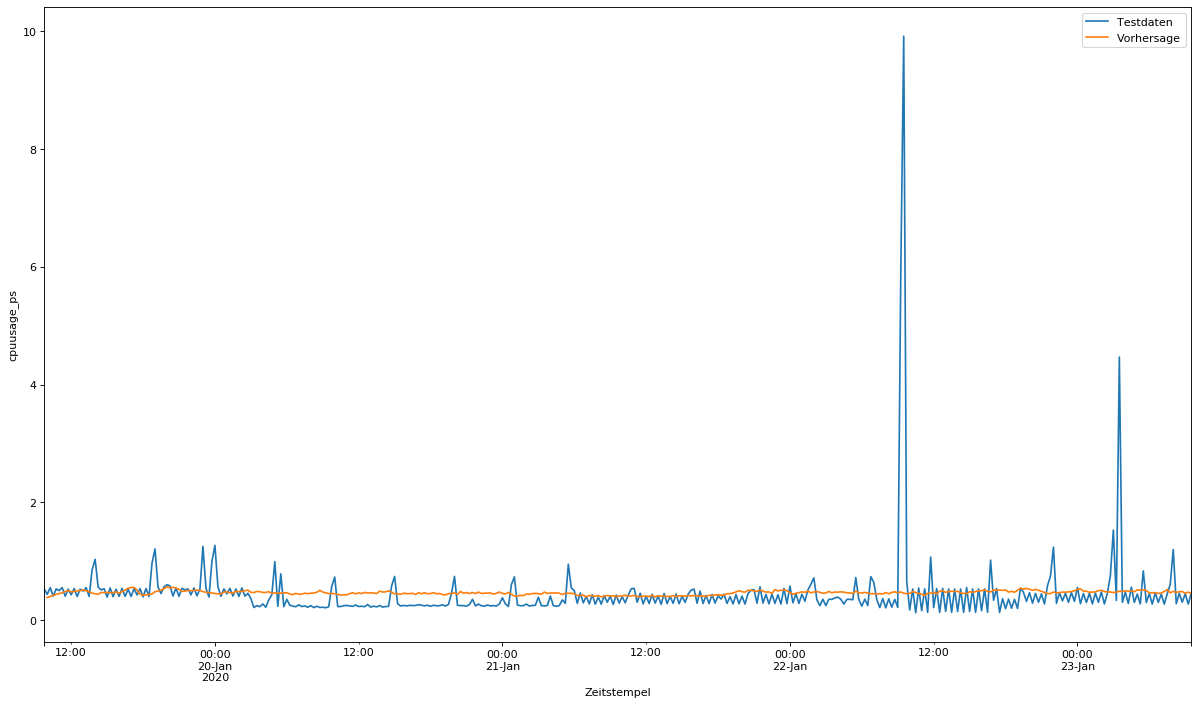

In [83]:
fig, ax = plt.subplots(figsize=(15,10),dpi=80, facecolor='w', edgecolor='k')
comparison_df.plot(ax=ax)

plt.legend(loc="upper right")
plt.xlabel("Zeitstempel")
plt.ylabel("cpuusage_ps")
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [72]:
fig.savefig("pblm2_CNN-Forecast")

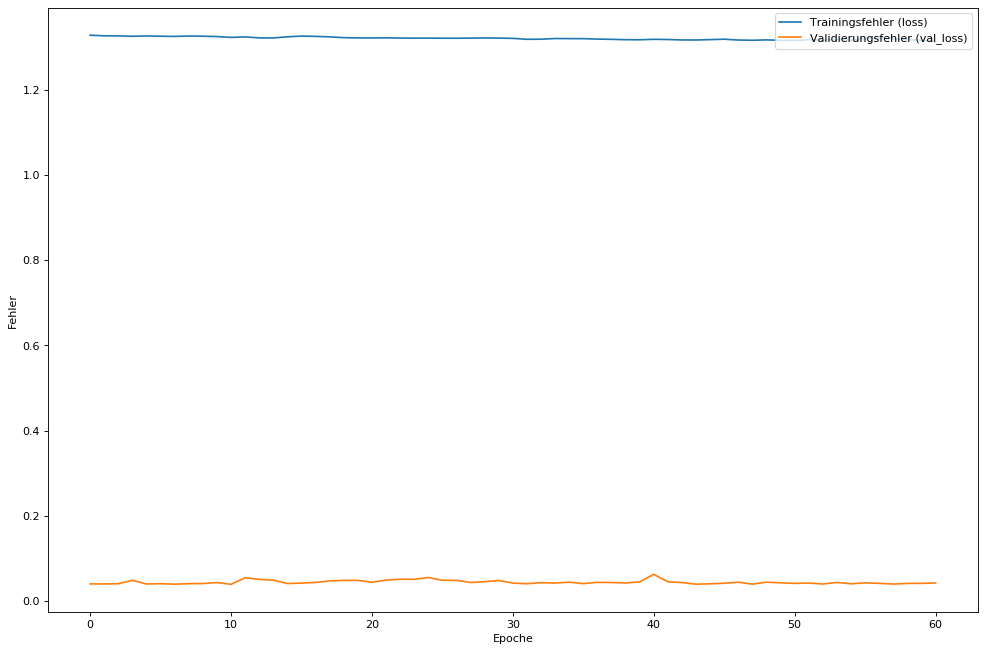

In [73]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(cnnHistory.history["loss"], label="Trainingsfehler (loss)")
plt.plot(cnnHistory.history["val_loss"], label="Validierungsfehler (val_loss)")
plt.xlabel("Epoche")
plt.ylabel("Fehler")
plt.legend(loc="upper right")

In [80]:
fig.savefig("pblm2_FehlerVerlauf")

In [80]:
# in 1day, out 4days
starttime = time.time()
train_lstm(df.copy().reset_index(), n_history=n_history, pred_horizon=pred_horizon, forcePreprocessing=True, performPCA=True)
print("training lstm took ", time.time() - starttime)

Preprocessing data...
 *** PCA Result***
 Started with 187 features, reduced to 62 features
SHAPES:  (2311, 96, 63) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1964, 96, 63) (1, 96, 63) (1964, 384) (1, 384) (346, 96, 63) (346, 384)
Train on 1964 samples, validate on 346 samples
Epoch 1/400
1964/1964 [==============================] - 23s 12ms/step - loss: 1.2328 - val_loss: 0.4508

Epoch 00001: val_loss improved from inf to 0.45083, saving model to switchedPca_lstm_multistep_multivariate.h5
Epoch 2/400
1964/1964 [==============================] - 24s 12ms/step - loss: 1.2281 - val_loss: 0.4535

Epoch 00002: val_loss did not improve from 0.45083
Epoch 3/400
1964/1964 [==============================] - 25s 13ms/step - loss: 1.2265 - val_loss: 0.4576

Epoch 00003: val_loss did not improve from 0.45083
Epoch 4/400
1964/1964 [==============================] - 25s 13ms/step - loss: 1.2251 - val_loss: 0.4515

Epoch 00004: val_loss did not improve from 0.45083
Epoch 5/400
1964/1964

In [81]:
# in: 1day, out: 4 day
starttime = time.time()
train_cnn(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True, performPCA=False)
print("training cnn took ", time.time() - starttime)

Preprocessing data...
SHAPES:  (2311, 96, 187) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (2079, 96, 187) (1, 96, 187) (2079, 384) (1, 384) (231, 96, 187) (231, 384)
Train on 2079 samples, validate on 231 samples
Epoch 1/400
2079/2079 [==============================] - 7s 3ms/step - loss: 1.1900 - val_loss: 0.4482

Epoch 00001: val_loss improved from inf to 0.44823, saving model to switchedPca_cnn_multistep_multivariate.h5
Epoch 2/400
2079/2079 [==============================] - 7s 3ms/step - loss: 1.1848 - val_loss: 0.4379 - ETA: 0s - loss: 1.18

Epoch 00002: val_loss improved from 0.44823 to 0.43793, saving model to switchedPca_cnn_multistep_multivariate.h5
Epoch 3/400
2079/2079 [==============================] - 7s 3ms/step - loss: 1.1649 - val_loss: 0.4333

Epoch 00003: val_loss improved from 0.43793 to 0.43331, saving model to switchedPca_cnn_multistep_multivariate.h5
Epoch 4/400
2079/2079 [==============================] - 7s 3ms/step - loss: 1.1392 - val_loss: 0.3763

In [82]:
# in: 1day, out: 4day
starttime = time.time()
train_gru(df.copy().reset_index(), pred_horizon=pred_horizon, n_history=n_history, forcePreprocessing=True, performPCA=True)
print("training GRU took ", time.time() - starttime)

Preprocessing data...
 *** PCA Result***
 Started with 187 features, reduced to 62 features
SHAPES:  (2311, 96, 63) (2311, 384)
Shapes: xtr, xte, ytr, yte, x_val, y_val:  (1964, 96, 63) (1, 96, 63) (1964, 384) (1, 384) (346, 96, 63) (346, 384)
Train on 1964 samples, validate on 346 samples
Epoch 1/400
1964/1964 [==============================] - 27s 14ms/step - loss: 1.2461 - mse: 1.2461 - val_loss: 0.4440 - val_mse: 0.4440

Epoch 00001: val_loss improved from inf to 0.44405, saving model to switchedPca_gru_multistep_multivariate.h5
Epoch 2/400
1964/1964 [==============================] - 25s 13ms/step - loss: 1.2322 - mse: 1.2322 - val_loss: 0.4470 - val_mse: 0.4470

Epoch 00002: val_loss did not improve from 0.44405
Epoch 3/400
1964/1964 [==============================] - 24s 12ms/step - loss: 1.2304 - mse: 1.2304 - val_loss: 0.4495 - val_mse: 0.4495

Epoch 00003: val_loss did not improve from 0.44405
Epoch 4/400
1964/1964 [==============================] - 23s 12ms/step - loss: 1.22

In [28]:
# Real data
plot_frames = []
plot_frames.append(plot_real_data_train(df, pred_horizon))
plot_frames.append(plot_real_data_test(df, pred_horizon))

In [29]:
plot_frames.append(forecast_gru(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon))

********MSE, RMSE, R^2******
MSE: 1.102706
RMSE: 1.050098
R squared: 0.796417


In [30]:
plot_frames.append(forecast_cnn(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon))

********MSE, RMSE, R^2******
MSE: 0.733657
RMSE: 0.856538
R squared: 0.864551


In [31]:
plot_frames.append(forecast_lstm(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon))

********MSE, RMSE, R^2******
MSE: 2.352324
RMSE: 1.533729
R squared: 0.565711


In [32]:
plot_frames.append(forecast_mlp(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon))

(1, 96, 63)
********MSE, RMSE, R^2******
MSE: 7.449325
RMSE: 2.729345
R squared: -0.375305


In [ ]:
plot_frames.append(forecast_fbprophet_additiv(pred_horizon))
plot_frames.append(forecast_fbprophet_boxcox(pred_horizon, fbprophet_boxcox_lam))

In [35]:
plot_frames.append(forecast_sarima(df.copy().reset_index(), n_history = n_history, pred_horizon = pred_horizon))

   cpuusage_ps
0       11.592
1        0.357
2        0.409
3        0.335
4        0.885
training sarima took  87.22043108940125


In [33]:
# Plot
plot_data(pd.concat(plot_frames, sort=True),'Vergleich ML-Models')